In [1]:
%matplotlib inline
%env JOBLIB_TEMP_FOLDER=/tmp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

import nltk
from nltk.corpus import stopwords
from os.path import join
from glob import glob

from time import time
from scipy.sparse import csr_matrix, lil_matrix

env: JOBLIB_TEMP_FOLDER=/tmp


In [3]:
with open('test_names.pkl', 'rb') as f:
    names = pickle.load(f)

count_vect = joblib.load('countVect.pkl')
dataset = count_vect.transform(names)

lda = joblib.load('lda.pkl')

In [4]:
class TopicModeler(object):

    def __init__(self, count_vect, lda):
        self.lda = lda
        self.count_vect = count_vect
        self.count_vect.input = 'content'
        
    def __call__(self, text):
        vectorized = self.count_vect.transform([text])
        lda_topics = self.lda.transform(vectorized)
        return lda_topics
    
    def get_keywords(self, text, n_topics=3, n_keywords=5):
        lda_topics = self(text)
        lda_topics = np.squeeze(lda_topics, axis=0)
        n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]
        
        top_topics_words_dists = []
        for i in n_topics_indices:
            top_topics_words_dists.append(self.lda.components_[i])
        
        keywords = np.zeros(shape=(n_keywords*n_topics, self.lda.components_.shape[1]))
        for i,topic in enumerate(top_topics_words_dists):
            n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
            for k,j in enumerate(n_keywords_indices):
                keywords[i * n_keywords + k, j] = 1
        keywords = self.count_vect.inverse_transform(keywords)
        keywords = [keyword[0] for keyword in keywords]
        return keywords  

In [5]:
ind = 18
with open(names[ind],'r') as f:
    text = f.read()
print(len(text))
print(names[ind])

22701
data/DiCh.txt


In [6]:
tm = TopicModeler(count_vect, lda)

In [33]:
key_words = tm.get_keywords(text, n_topics=1, n_keywords=10)
print(key_words)

['маникюр', 'волос', 'стоимость', 'product', 'наращивание', 'лс', 'комната', 'окрашивание', 'гель', 'лак']


In [14]:
text

'Свободный вздох без пластика нам еще не светит, и даже не мерцает. Но длинный путь подвластен маленьким шагам. \nЕсть ли среди наших подписчиков, стремящиеся к безотходности? Или просто осваивающие маленькие, но невероятно важные эко-привычки? Расскажите как вы до этого докатились?\nА на фото платье Арма в новом винном цвете.\n#zerowaste #экопривычки #безпластика #Sustainable #устойчиваямода Рубашка Ромб-универсальный солдат гардероба.\nБрюки, джинсы, легинсы, велосипедки, обнаженные ноги-всё это подходит Ромбу.\nМы создали его в светло-сером цвете, в цвете бутылочного стекла и в цвете бордо. 🐶Пёсики и котики очень ждут нас и нашей помощи! 🐈\n30-31 Марта в рамках маркета [club168769915|GARAGE SALE SPB] мы будем представлять корнер гаражной распродажи вещей нашей команды. Все 100% выручки от продаж будет перечислено [club190703|Приюту для бездомных животных "Ржевка"] \nНо мы не остановимся на этом и презентуем хвостатым 20% от продаж на маркете одежды марки [club47286378|DiCh] \nВпервы

In [15]:
sorted_words_coeffs = lda.components_.argsort(axis=1)
n_top = 10
top_coefs = sorted_words_coeffs[:,-n_top:][:,::-1]

vect_texts = np.zeros((top_coefs.shape[0], lda.components_.shape[1]),
                       )
for i,n_top_coefs in enumerate(top_coefs):
    for coef in n_top_coefs:
        vect_texts[i,coef] = 1


In [16]:
top_words = count_vect.inverse_transform(vect_texts)
top_words_set = set()
for words in top_words:
    top_words_set.update(set(words))
print(len(top_words_set))

452


In [17]:
voc_to_idf = {word : i for i, word in enumerate(top_words_set)}

with open('stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

with open('train_names.pkl', 'rb') as f:
    train_names = pickle.load(f)

In [18]:
tfidf_tw = TfidfVectorizer(input='filename', vocabulary=voc_to_idf, stop_words=stopwords)
tfidf_tw.fit(train_names)

idfs = tfidf_tw.idf_
print(idfs.shape)

(452,)


In [19]:
n_top = int(idfs.shape[0] * 0.05)

n_top_indices = np.argsort(idfs)[:n_top]

vect_words = np.zeros((n_top, len(idfs)))

In [20]:
inv_voc_to_idf = { voc_to_idf[key] : key for key in voc_to_idf.keys()}
extra_stop_words = []
for ind in n_top_indices:
    extra_stop_words.append(inv_voc_to_idf[ind])
print(len(extra_stop_words))

22


In [21]:
print(extra_stop_words)

['это', 'очень', 'время', 'день', 'просто', 'лет', 'новый', 'нужно', 'каждый', 'человек', 'сделать', 'первый', 'год', 'несколько', 'жизнь', 'место', 'наш', 'делать', 'внимание', 'скоро', 'мир', 'возможность']


In [23]:
stopwords = stopwords + extra_stop_words
with open('stopwords_updated.pkl', 'wb') as f:
    pickle.dump(stopwords, f)

In [24]:
with open('test_names.pkl', 'rb') as f:
    names = pickle.load(f)

count_vect = joblib.load('countVect.pkl')
dataset = count_vect.transform(names)

lda = joblib.load('lda.pkl')

In [25]:
term_doc_matrix = count_vect.transform(names)
embeddings = lda.transform(term_doc_matrix)

In [26]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AffinityPropagation, SpectralClustering, KMeans

In [27]:
kmeans = KMeans(n_clusters=30)
clust_labels = kmeans.fit_predict(embeddings)
clust_centers = kmeans.cluster_centers_

In [28]:
embeddings_to_tsne = np.concatenate((embeddings,clust_centers), axis=0)

tSNE =  TSNE(n_components=2, perplexity=15)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [29]:
print(tsne_embeddings.shape,centroids_embeddings.shape)

(369, 2) (30, 2)


In [30]:
clust_indices = np.unique(clust_labels)

clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

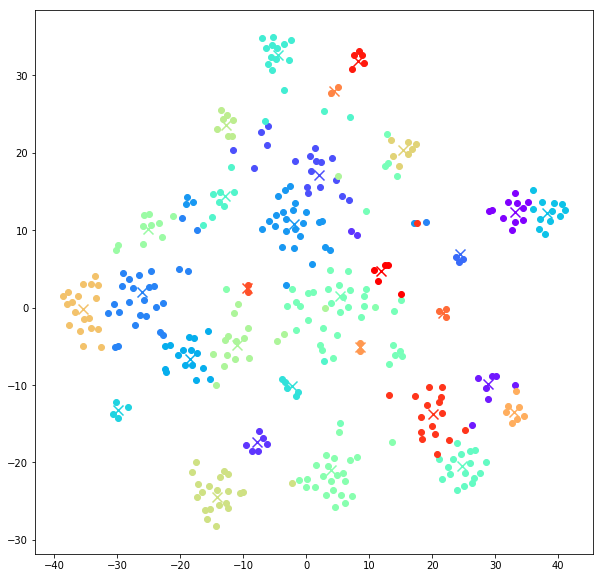

In [31]:
plt.figure(figsize=(10,10))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

plt.show()